In [1]:
import random, datetime
import gym
from gym import error, spaces
import pandas as pd
import numpy as np
from enum import Enum
from stockstats import StockDataFrame
from sklearn import preprocessing

In [2]:
import gym
import datetime as dt
import matplotlib.pyplot as plt

# from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLstmPolicy, ActorCriticPolicy, LstmPolicy
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import PPO2, PPO1, A2C, DQN, TD3, SAC

# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from sklearn import preprocessing

import pandas as pd

from lutils.stock import LTdxHq

In [6]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_NUM_AMOUNTS = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 60
MAX_STEPS = 240 # 40000
NEXT_OBSERVATION_SIZE = 10

INITIAL_ACCOUNT_BALANCE = 10000

In [3]:
class Actions(Enum):
    Hold = 0
    Sell = 1
    Buy = 2

In [4]:
class LStockDailyEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df=None):
        super(LStockDailyEnv, self).__init__()

        self.df = df
        self.current_step = NEXT_OBSERVATION_SIZE

        # self.reward_range = (0, MAX_ACCOUNT_BALANCE)
        # self.reward_range = (0, 1)
        # self.reward_range = (0, 100)
        self.reward_range = (-np.inf, np.inf)

        self.action_space = spaces.Discrete(len(Actions))

        self.observation_space = spaces.Box(low=0, high=1, shape=(14, NEXT_OBSERVATION_SIZE), dtype=np.float32)

        # self.min_max_scaler = preprocessing.MinMaxScaler()
        self.scaler = preprocessing.RobustScaler()

    def seed(self, seed=None):
        pass


    def _next_observation(self):
        if self.df is None:
            return None

        frame = np.array([ # 11 * 10
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open'].values, # / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high'].values, # / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low'].values, # / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close'].values, # / MAX_SHARE_PRICE,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume'].values, # / MAX_NUM_SHARES,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount'].values, # / MAX_NUM_SHARES,
            
            # self.df['close'].pct_change().fillna(0)[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE],

            self.df['macd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['macdh'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['macds'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            # # self.df['volume_delta'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_2_d'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_-2_r'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['cr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['cr-ma1'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['cr-ma2'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['cr-ma3'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            self.df['kdjk'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['kdjd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['kdjj'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].values,
            self.df['rsi_6'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            self.df['rsi_12'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            # self.df['open_2_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['dma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['pdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['mdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['dx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['adx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['adxr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['tema'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['vr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['vr_6_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,

            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['open'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['high'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['low'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['close'].values,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['volume'].values,
        ])

        # if frame.shape[1] == 0:
        #     print(self.current_step)

        # frame = self.min_max_scaler.fit_transform(frame)
        # frame = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
        frame = self.scaler.fit_transform(frame)

        return frame


    def step(self, action):

        current_price = self.df.iloc[self.current_step]['close']

        is_tran = False
        if action == Actions.Buy.value and (self.balance / current_price) > 1:
            # Buy amount % of balance in shares
            current_price = current_price
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

            is_tran = True
        elif action == Actions.Sell.value and self.shares_held > 0:
            current_price = current_price
            shares_sold = int(self.shares_held)

            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

            is_tran = True

        # next time net_worth
        self.net_worth = self.balance + self.shares_held * self.df.iloc[self.current_step]['close']

        ###################################################################################

        done = self.net_worth <= INITIAL_ACCOUNT_BALANCE * .9 or self.current_step + 1 >= self.df.shape[0] # or datetime.datetime.strptime(self.df.index[self.current_step], '%Y-%M-%d').weekday() == 4


        reward = 0
        if is_tran:
            reward = self.net_worth - INITIAL_ACCOUNT_BALANCE
        else:
            reward = -10
        # if done:
        #     reward = self.net_worth - INITIAL_ACCOUNT_BALANCE

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        self.current_step = self.current_step + 1
        obs = self._next_observation()

        return obs, reward, done, {'net_worth': self.net_worth, 'current_step': self.current_step}

    def reset(self):
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        if self.current_step > self.df.shape[0] - NEXT_OBSERVATION_SIZE:
            self.current_step = NEXT_OBSERVATION_SIZE

        return self._next_observation()

    def render(self, mode='human', close=False):
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 257  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 255          |
|    iterations           | 2            |
|    time_elapsed         | 16           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011080481 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 5.36e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.49e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00214     |
|    value_loss           | 1.84e+08     |
-----------------------------------------

[2] [False]
Step: 62
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 10307.32 (Max net worth: 11560.239999999998)
Profit: 307.3199999999997
[2] [False]
Step: 63
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 10118.199999999999 (Max net worth: 11560.239999999998)
Profit: 118.19999999999891
[2] [False]
Step: 64
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 10094.559999999998 (Max net worth: 11560.239999999998)
Profit: 94.55999999999767
[2] [False]
Step: 65
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 10094.559999999998 (Max net worth: 11560.239999999998)
Profit: 94.55999999999767
[2] [False]
Step: 66
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg c

[2] [False]
Step: 115
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9976.359999999999 (Max net worth: 11560.239999999998)
Profit: -23.640000000001237
[2] [False]
Step: 116
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9810.88 (Max net worth: 11560.239999999998)
Profit: -189.1200000000008
[2] [False]
Step: 117
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9716.32 (Max net worth: 11560.239999999998)
Profit: -283.6800000000003
[2] [False]
Step: 118
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9739.96 (Max net worth: 11560.239999999998)
Profit: -260.0400000000009
[2] [False]
Step: 119
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held sh

[2] [False]
Step: 168
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9763.599999999999 (Max net worth: 11560.239999999998)
Profit: -236.40000000000146
[2] [False]
Step: 169
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9834.519999999999 (Max net worth: 11560.239999999998)
Profit: -165.48000000000138
[2] [False]
Step: 170
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9669.039999999999 (Max net worth: 11560.239999999998)
Profit: -330.96000000000095
[2] [False]
Step: 171
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0)
Avg cost for held shares: 4.23 (Total sales value: 0)
Net worth: 9810.88 (Max net worth: 11560.239999999998)
Profit: -189.1200000000008
[2] [False]
Step: 172
Balance: 0.27999999999883585
Shares held: 2364 (Total sold: 0

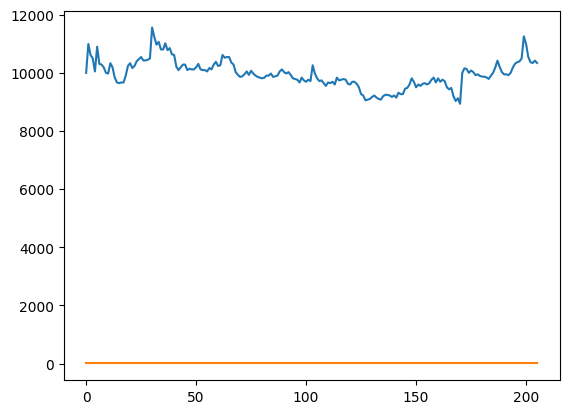

In [7]:
ltdxhq = LTdxHq()
code = '603828' # 000032 300142 603636 600519 600519
# df = ltdxhq.get_k_data_1min(code, end='2021-09-02') # 000032 300142 603636 600519
df = ltdxhq.get_k_data_daily(code, end='2021-01-01') # 000032 300142 603636 600519
df = StockDataFrame(df.rename(columns={'vol': 'volume'}))

df['ma21'] = df['close'].rolling(window=20, min_periods=1).mean()
df['trend'] = df.close.diff().fillna(0) / df.close

# min_max_scaler = preprocessing.MinMaxScaler()
# # df = pd.DataFrame(min_max_scaler.fit_transform(df))
# df = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
# print(df)
# df_eval = df[df.index >= '2021-01-01']
# df = df[df.index < '2021-01-01']
# df = pd.DataFrame(min_max_scaler.fit_transform(df.drop(columns=['date', 'code'])))
# df.columns = ['open', 'close', 'high', 'low', 'volume', 'amount']

# df_eval = ltdxhq.get_k_data_1min(code, start='2021-08-10')
_df = ltdxhq.get_k_data_daily(code, start='2021-01-01')

_df['ma21'] = _df['close'].rolling(window=20, min_periods=1).mean()
_df['trend'] = _df.close.diff().fillna(0) / _df.close

df_eval = _df['2021-01-01':] # ltdxhq.get_k_data_daily(code, start='2021-01-01')
df_eval = StockDataFrame(df_eval.rename(columns={'vol': 'volume'}))

ltdxhq.close()
# df = ltdxhq.get_k_data_5min('603636')
# df = ltdxhq.get_k_data_daily('603636')

# df1 = df[:-240]
# df2 = df[-240:]
# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: LStockDailyEnv(df)])
# model = PPO2(MlpPolicy, env, verbose=1) # , tensorboard_log='log')
model = PPO('MlpPolicy', env, verbose=1) # , tensorboard_log='log')
model.learn(20000)
# model = PPO1(LstmPolicy, env, verbose=1)
# model.learn(total_timesteps=1000)

model.save('ppo_stock')
# model = PPO.load('ppo_stock')

eval_env = DummyVecEnv([lambda: LStockDailyEnv(df_eval)])
obs = eval_env.reset()

net_worths = []
actions = []
done, state = False, None
# while not done:
for _ in range(NEXT_OBSERVATION_SIZE, df_eval.shape[0]):
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _info = eval_env.step(action)
    print(action, done)
    net_worths.append(_info[0]['net_worth'])
    # if is_recurrent:
    #     obs[0, :] = new_obs
    # else:
    #     obs = new_obs

    # if action[0] < Actions.Buy: # Buy
    #     actions.append(1)
    # elif action[0] < Actions.Sell: # Sell
    #     actions.append(2)
    # else:
    #     actions.append(0)
    actions.append(action[0])
    eval_env.render()

plt.plot(net_worths)
plt.plot(actions)
plt.show()

In [8]:
actions

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]